In [3]:
import argparse
import datetime
import random
import time
from pathlib import Path
import os, sys
sys.path.append("C:/Users/piyalong/CrowdCounting-P2PNet/")
import torch
import torchvision.transforms as standard_transforms
import numpy as np

from PIL import Image
import cv2
from crowd_datasets import build_dataset
from engine import *
from models import build_model
import os
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from shapely.geometry import Point as P
from shapely.geometry.polygon import LinearRing, Polygon
torch.cuda.empty_cache() 
import cv2
import json
import pandas as pd

In [2]:
def study_zone(im_path,json_path):
    
    img = cv2.imread(im_path)
    studyzones=json_path

    pixelzones = {}
    with open(studyzones, 'r') as json_file:
        zones = json.load(json_file)
        for each in (zones['shapes']):
            pixelzones.update({each['label']:each['points']})
    for zonename,check_zone in pixelzones.items():
        pts = np.array(check_zone, np.int32)
        for i,checkline in enumerate(check_zone):
            p1,p2 = (check_zone[i],check_zone[i-1])
        pts = pts.reshape((-1, 1, 2))
        im=cv2.polylines(img,[pts],True,(0,255,255),10)
        
        im=cv2.putText(img,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 5)

        
    plt.imshow(im)
    return pixelzones

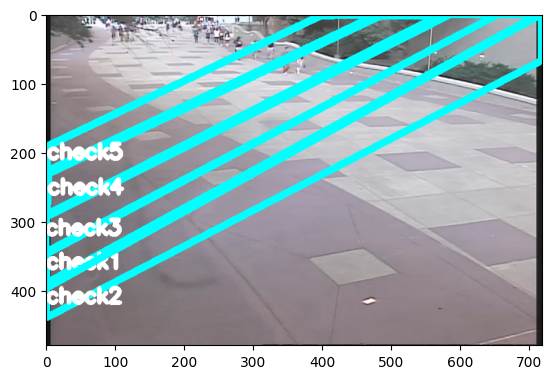

In [3]:
pixelzones = study_zone('C:/Users/piyalong/Pictures/WCG _ PTZ PW Outside East View (SC4)-2022-09-10_17h00min00s000ms_Moment.jpg',
                        'C:/Users/piyalong/Pictures/WCG _ PTZ PW Outside East View (SC4)-2022-09-10_17h00min00s000ms_Moment.json')

In [4]:
pixelzones

{'check1': [[656.0, 0.0],
  [715.7587939698492, 0.0],
  [0.0, 390.0],
  [1.4874371859296645, 347.57788944723586]],
 'check2': [[719.0, 0.0], [719.0, 67.0], [0.0, 440.0], [0.0, 397.0]],
 'check3': [[587.8592964824114, -0.6180904522612849],
  [656.9849246231155, 0.4924623115577873],
  [-1.0150753768845107, 345.49246231155786],
  [0.6733668341707642, 294.462311557789]],
 'check4': [[485.105527638191, 2.0100502512562812],
  [570.5326633165829, 2.0100502512562812],
  [1.6884422110552748, 290.45226130653265],
  [3.1959798994974875, 231.65829145728642]],
 'check5': [[398.67336683417085, 2.512562814070352],
  [482.0904522613065, 0.5025125628140703],
  [0.1809045226130621, 228.643216080402],
  [2.1909547738693504, 191.4572864321608]]}

In [5]:
class Point:
	def __init__(self,x,y):
		self.x = x
		self.y = y

def ccw(A,B,C):
	return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def intersect(A,B,C,D):
	return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def check_cross(checkline, traj_line):
    
    previous_x,previous_y = traj_line[1][0],traj_line[1][1]
    next_x,next_y = traj_line[0][0],traj_line[0][1]
    
    return intersect(Point(previous_x,previous_y), Point(next_x,next_y),Point(checkline[0][0],checkline[0][1]),Point(checkline[1][0],checkline[1][1]))


In [6]:
def read_detection(folder):
    total_leaving = {i:{} for i in pixelzones.keys()}

    total_entering = {i:{}  for i in pixelzones.keys()}

    fps=15
    
    for file in os.listdir(folder):
        if not file.endswith('.npy'):continue
        if 'Outside' not in file:continue
        data=np.load(folder+file,allow_pickle=True)

        print(file)

        for ID in  data.item():
            every_trace = data.item()[ID]
            txt=file
            date = txt[txt.find("min")-16:txt.find("min")-6]
            hrs = txt[txt.find("min")-5:txt.find("min")-3]
            minute = txt[txt.find("min")-2:txt.find("min")]
            second = txt[txt.find("min")+3:txt.find("min")+5]
            t = pd.to_datetime(date+' '+hrs+':'+minute+':'+second)
            for x ,trace in enumerate(every_trace):
                if x <=1 :continue
                traj_line = [every_trace[x-1],every_trace[x]]
                first_point = P(traj_line[0])
                last_point = P(traj_line[1])
                frame = trace[-1]
                current_t = t + datetime.timedelta(0,frame/fps)
                for zonename,check_zone in pixelzones.items():
                    zone = Polygon(check_zone)
                    for i in range(0,len(check_zone)):
                        checkline = [check_zone[i],check_zone[i-1]]

                        if check_cross(checkline,traj_line) :
                            if  zone.contains(last_point,):
                                total_entering[zonename].update({current_t:1})
                            if  zone.contains(first_point):
                                total_leaving[zonename].update({current_t:1})

    interval='1min'

    # df_leave = pd.read_csv('Outside_total_leave.csv',index_col = 0, parse_dates=True)
    df_leave = pd.DataFrame(total_leaving)
    # df_leave.to_csv('Outside_total_leave.csv')

    # df_enter = pd.read_csv('Outside_total_enter.csv',index_col = 0, parse_dates=True)
    df_enter = pd.DataFrame(total_entering)
    # df_enter.to_csv('Outside_total_enter.csv')


    to_plot = (df_leave.resample(interval).agg('sum')+df_enter.resample(interval).agg('sum'))/2


    return to_plot

In [7]:
miami = read_detection('D:/2022 season/Miami/')

WCG _ PTZ PW Outside East View (SC4)-2022-09-17_23h00min00s000ms.npy
WCG _ PTZ PW Outside East View (SC4)-2022-09-18_00h00min00s000ms.npy
WCG _ PTZ PW Outside East View (SC4)-2022-09-18_01h00min00s000ms.npy


In [8]:
appastate=read_detection('D:/2022 season/Appa State/')

WCG _ PTZ PW Outside East View (SC4)-2022-09-10_17h00min00s000ms.npy
WCG _ PTZ PW Outside East View (SC4)-2022-09-10_18h00min00s000ms.npy
WCG _ PTZ PW Outside East View (SC4)-2022-09-10_18h00min00s000ms_.npy
WCG _ PTZ PW Outside East View (SC4)-2022-09-10_19h00min00s000ms.npy


Text(0.5, 1.0, 'Outside with 1 Minute Interval, MIAMI,Total (P): 19423')

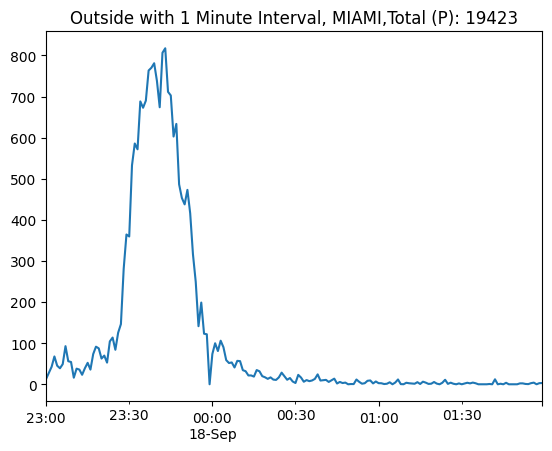

In [9]:
miami.to_csv('Miami_Outside.csv')
miami.mean(axis=1).plot()
plt.title('Outside with 1 Minute Interval, MIAMI,Total (P): '+str(round(miami.mean(axis=1).to_numpy().sum())))
# miami.mean(axis=1).to_csv('OutsideMiami.csv')

Text(0.5, 1.0, 'Outside with 1 Minute Interval, APPA,Total (P): 34457')

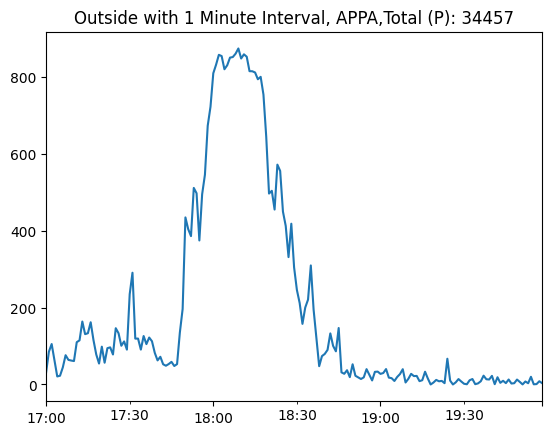

In [10]:
appastate.to_csv('AppaState_Outside.csv')


appastate.mean(axis=1).plot()
plt.title('Outside with 1 Minute Interval, APPA,Total (P): '+str(round(appastate.mean(axis=1).to_numpy().sum())))
# appastate.to_csv('OutsideAppa.csv')

<AxesSubplot:xlabel='Time'>

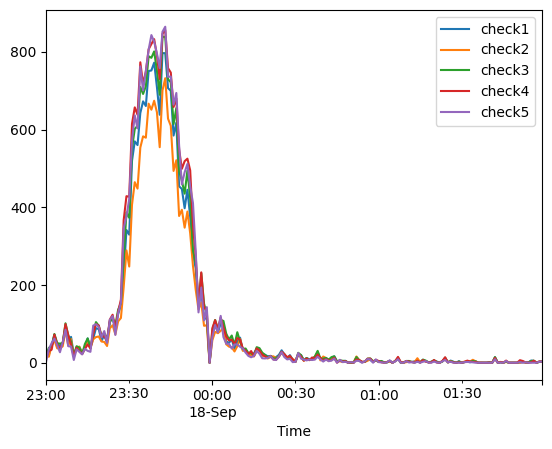

In [4]:
miami = pd.read_csv('Miami_Outside.csv',parse_dates=['Unnamed: 0'])
miami=miami.set_index('Unnamed: 0')
miami.index.name='Time'


miami.plot()



<AxesSubplot:xlabel='Time'>

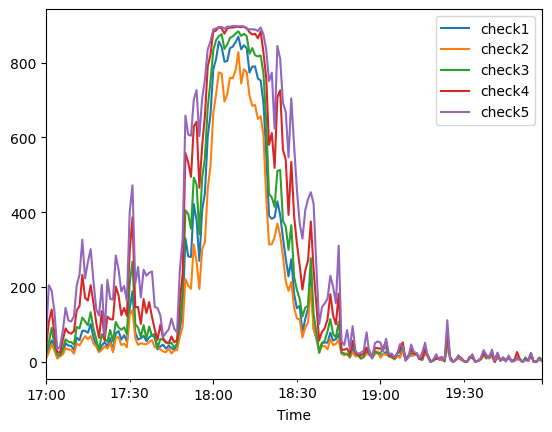

In [5]:
appastate = pd.read_csv('AppaState_Outside.csv',parse_dates=['Unnamed: 0'])
appastate=appastate.set_index('Unnamed: 0')
appastate.index.name='Time'

appastate.plot()

In [17]:
miami.mean(axis=1).sum()

19423.399999999998

In [18]:
appastate.mean(axis=1).sum()

31101.7

In [11]:
df1=miami.mean(axis=1)

In [ ]:
x = df1['Minutes']
# x[x =="Game End"] = 0
x = df1['Minutes'].to_numpy().astype('float64')
y=df1[game].to_numpy().astype('float64')

fit = np.polyfit(x, y, 5)
fit_fn = np.poly1d(fit)

In [13]:
df1

Time
2022-09-17 23:00:00    12.9
2022-09-17 23:01:00    28.0
2022-09-17 23:02:00    42.7
2022-09-17 23:03:00    67.7
2022-09-17 23:04:00    45.2
                       ... 
2022-09-18 01:55:00     2.7
2022-09-18 01:56:00     4.0
2022-09-18 01:57:00     0.0
2022-09-18 01:58:00     2.7
2022-09-18 01:59:00     3.0
Length: 180, dtype: float64